In [ ]:
!pip install librosa kaggle joblib-progress pandas numpy matplotlib seaborn tensorflow[and-cuda] tensorrt
# %conda install -c conda-forge keras-preprocessing

In [ ]:
# !echo $(dirname $(python -c "import nvidia.cudnn;print(nvidia.cudnn.__file__)"))
#LD_LIBRARY_PATH=${CUDNN_PATH}/lib

%env CUDNN_PATH=/home/timur/miniforge3/envs/rzd/lib/python3.11/site-packages/nvidia/cudnn
%env LD_LIBRARY_PATH=/home/timur/miniforge3/envs/rzd/lib/python3.11/site-packages/nvidia/cudnn/lib
%env CUDA_VISIBLE_DEVICES=0

env: CUDNN_PATH=/home/timur/miniforge3/envs/rzd/lib/python3.11/site-packages/nvidia/cudnn
env: LD_LIBRARY_PATH=/home/timur/miniforge3/envs/rzd/lib/python3.11/site-packages/nvidia/cudnn/lib
env: CUDA_VISIBLE_DEVICES=0


In [ ]:
!echo $CUDNN_PATH
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
tf.config.set_visible_devices(gpus[0], 'GPU')
print(tf.config.get_visible_devices())

/home/timur/miniforge3/envs/rzd/lib/python3.11/site-packages/nvidia/cudnn


2024-06-15 12:34:19.893495: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


2024-06-15 12:34:22.798823: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-06-15 12:34:23.153986: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-06-15 12:34:23.154187: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

Будем использовать датасеты SAVEE, RAVDESS, CREMA-D, TESS, RESD

In [ ]:
import os
os.environ['KAGGLE_USERNAME'] = "tim0820"
os.environ['KAGGLE_KEY'] = "e8f8510dac43db1d8218445c8cc13483"

import kaggle
import urllib.request
import tarfile

kaggle.api.authenticate()

datasets_paths = {
    "savee": "./SAVEE_dataset/",
    "ravdess": "./RAVDESS_dataset/",
    "cremad": "./CREMA_dataset/",
    "tess": "./TESS_dataset/",
    "resd": "./RESD_dataset/",
    "serec": "./SEREC_dataset/",
    "dusha": "./DUSHA_dataset/",
}

check = any([not os.path.exists(i) for i in datasets_paths.values()]) # Check if all datasets are downloaded
if check:
    kaggle.api.dataset_download_files('uwrfkaggler/ravdess-emotional-speech-audio', path=datasets_paths['ravdess'], unzip=True)
    kaggle.api.dataset_download_files('ejlok1/surrey-audiovisual-expressed-emotion-savee', path=datasets_paths['savee'], unzip=True)
    kaggle.api.dataset_download_files('ejlok1/cremad', path=datasets_paths['cremad'], unzip=True)
    kaggle.api.dataset_download_files('ejlok1/toronto-emotional-speech-set-tess', path=datasets_paths['tess'], unzip=True)
    kaggle.api.dataset_download_files('ar4ikov/resd-dataset', path=datasets_paths['resd'], unzip=True)
    kaggle.api.dataset_download_files('anuvagoyal/speech-emotion-recognition-for-emergency-calls', path=datasets_paths['serec'], unzip=True)
    # urllib.request.urlretrieve("https://huggingface.co/datasets/KELONMYOSA/dusha_emotion_audio/resolve/main/data/train.tar.gz?download=true", "dusha.tar.gz")
    # tar = tarfile.open("dusha.tar.gz", "r:gz")
    # tar.extractall(path=datasets_paths['dusha'])
    # tar.close()


In [ ]:
import pandas as pd
import numpy as np
import librosa
import re
import os
import shutil
from IPython.display import Audio, display
from tqdm import tqdm
from joblib import Parallel, delayed
from joblib_progress import joblib_progress
import tensorflow as tf
import pickle

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

# **1. Ravdess - структура данных**
* Формат (01 = full-AV, 02 = video-only, 03 = audio-only).
* Вокальный канал (01 = speech, 02 = song).
* Эмоция (01 = neutral, 02 = calm, 03 = happy, 04 = sad, 05 = angry, 06 = fearful, 07 = disgust, 08 = surprised).
* Интенсивность эмоции (01 = normal, 02 = strong)
* Выражение (01 = "Kids are talking by the door", 02 = "Dogs are sitting by the door").
* Повтор? (01 = 1st repetition, 02 = 2nd repetition).
* Говорящий (01 to 24. Дикторы с нечётным номером мужчины, а с чётным - женщины).

Вот пример имени фийла. 02-01-06-01-02-01-12.mp4
Это обозначает, что:

* Только видео (02)
* Речь (не пение) (01)
* Эмоция - страх (06)
* Нормальная интенсивность (01)
* Выражение про собак (02)
* Первый повтор (01)
* 12 диктор (12) - Женщина (as the actor ID number is even)

In [ ]:
ravdess_df = pd.DataFrame()
emotions, paths = [], []

ravdess_dir_list = os.listdir(datasets_paths['ravdess'])
ravdess_dir_list = [dirname for dirname in ravdess_dir_list if re.match(r'^Actor_\d{2}$', dirname)]

for dirname in ravdess_dir_list:
    actor = os.listdir(datasets_paths['ravdess'] + dirname + '/')
    for filename in actor:
        part = filename.split('.')[0]
        part = part.split('-')

        # Allow speech only, skip song (second part in each filename represents the vocal channel)
        if int(part[1]) == 1:
            # third part in each filename represents the emotion
            emotions.append(int(part[2]))
            paths.append(str(datasets_paths['ravdess'] + dirname + '/' + filename))

ravdess_df = pd.DataFrame(
    {
        'Emotions': emotions,
        'Path': paths,
    },
    columns=['Emotions', 'Path'],
    )
# ravdess_df.Emotions.replace({1:'neutral', 2:'neutral', 3:'happy', 4:'sad', 5:'angry', 6:'fear', 7:'disgust', 8:'happy'}, inplace=True)
ravdess_df.Emotions.replace({1:'good', 2:'good', 3:'good', 4:'bad', 5:'bad', 6:'bad', 7:'bad', 8:'good'}, inplace=True)
ravdess_df.head()

/tmp/ipykernel_120622/1159874241.py:27: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  ravdess_df.Emotions.replace({1:'good', 2:'good', 3:'good', 4:'bad', 5:'bad', 6:'bad', 7:'bad', 8:'good'}, inplace=True)


,Emotions,Path
0,good,./RAVDESS_dataset/Actor_02/03-01-01-01-01-01-0...
1,good,./RAVDESS_dataset/Actor_02/03-01-01-01-01-02-0...
2,good,./RAVDESS_dataset/Actor_02/03-01-01-01-02-01-0...
3,good,./RAVDESS_dataset/Actor_02/03-01-01-01-02-02-0...
4,good,./RAVDESS_dataset/Actor_02/03-01-02-01-01-01-0...


# **SAVEE - структура данных**
* KL=angry
* JK=happy
* JE=sad
* DC=neutral

Самый сомнительный из всех. В нём даже человеку не совсем ясно какая эмоция. Что обозначают цыфры и буквы после обозначений - непонятно.

In [ ]:
savee_df = pd.DataFrame()
emotions, paths = [], []

savee_dir_list = os.listdir(datasets_paths['savee'] + "/ALL/")

for filename in savee_dir_list:
    emotions.append(filename[:2])
    paths.append(str(datasets_paths['savee'] + "ALL/" + filename))

savee_df = pd.DataFrame(
    {
        'Emotions': emotions,
        'Path': paths,
    },
    columns=['Emotions', 'Path'],
    )
# savee_df.Emotions.replace({"DC":'neutral', "JK":'happy', "JE":'sad', "KL":'angry'}, inplace=True)
savee_df.Emotions.replace({"DC":'good', "JK":'good', "JE":'bad', "KL":'bad'}, inplace=True)

savee_df.head()

/tmp/ipykernel_64888/1407191946.py:18: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  savee_df.Emotions.replace({"DC":'good', "JK":'good', "JE":'bad', "KL":'bad'}, inplace=True)


,Emotions,Path
0,good,./SAVEE_dataset/ALL/DC_a01.wav
1,good,./SAVEE_dataset/ALL/DC_a02.wav
2,good,./SAVEE_dataset/ALL/DC_a03.wav
3,good,./SAVEE_dataset/ALL/DC_a04.wav
4,good,./SAVEE_dataset/ALL/DC_a05.wav


# **CREMA(-D) - структура данных**

Название файла формата 1001_HAP_SAD_XX.wav, где HAP - условное обозначение эмоции

* 'ANG' = 'angry'
* 'DIS' = 'disgust'
* 'FEA' = 'fear'
* 'HAP' = 'happiness'
* 'NEU' = 'neutral'
* 'SAD' = 'sad'
* 'SUP' = 'surprise'

In [ ]:
cremad_df = pd.DataFrame()
emotions, paths = [], []

cremad_dir_list = os.listdir(datasets_paths['cremad'] + 'AudioWAV/')

for filename in cremad_dir_list:
    part = filename.split('.')[0]
    part = part.split('_')

    # third part in each filename represents the emotion
    emotions.append(part[2])
    paths.append(str(datasets_paths['cremad'] + 'AudioWAV/' + filename))

cremad_df = pd.DataFrame(
    {
        'Emotions': emotions,
        'Path': paths,
    },
    columns=['Emotions', 'Path'],
    )

# cremad_df.Emotions.replace({"NEU":'neutral', "HAP":'happy', "SAD":'sad', "ANG":'angry', "FEA":'fear', "DIS":'angry', "SUP":'happy'}, inplace=True)
cremad_df.Emotions.replace({"NEU":'good', "HAP":'good', "SAD":'bad', "ANG":'bad', "FEA":'bad', "DIS":'bad', "SUP":'good'}, inplace=True)

cremad_df.head()


/tmp/ipykernel_64888/816460251.py:23: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  cremad_df.Emotions.replace({"NEU":'good', "HAP":'good', "SAD":'bad', "ANG":'bad', "FEA":'bad', "DIS":'bad', "SUP":'good'}, inplace=True)


,Emotions,Path
0,bad,./CREMA_dataset/AudioWAV/1001_DFA_ANG_XX.wav
1,bad,./CREMA_dataset/AudioWAV/1001_DFA_DIS_XX.wav
2,bad,./CREMA_dataset/AudioWAV/1001_DFA_FEA_XX.wav
3,good,./CREMA_dataset/AudioWAV/1001_DFA_HAP_XX.wav
4,good,./CREMA_dataset/AudioWAV/1001_DFA_NEU_XX.wav


# **TESS - структура данных**

Содержит папки формата XXX_emotion, в каждой папке своя эмоция своего диктора (но диктор нам не важен)

* 'Fear' = 'fear'
* 'Pleasant_surprise' = 'surprise'
* 'Pleasant_surprised' = 'surprise'
* 'Sad' = 'sad'
* 'angry' = 'angry'
* 'neutral' = 'neutral'
* 'disgust' = 'disgust'
* 'happy' = 'happy'

Эта версия датасета плохо отформатирована

In [ ]:
tess_df = pd.DataFrame()
emotions, paths = [], []

tess_dir_list = os.listdir(datasets_paths['tess'] + "TESS Toronto emotional speech set data/")
for dirname in tess_dir_list:
    emo = os.listdir(datasets_paths['tess'] + "TESS Toronto emotional speech set data/" + dirname)
    for filename in emo:
        part = ''.join(dirname.split('_')[1:])
        part = part.lower().replace('_', '').replace('pleasant', '').replace('surprised', 'surprise')
        emotions.append(part)
        paths.append(datasets_paths['tess'] + "TESS Toronto emotional speech set data/" + dirname + "/" + filename)

tess_df = pd.DataFrame(
    {
        'Emotions': emotions,
        'Path': paths,
    },
    columns=['Emotions', 'Path'],
    )
# ravdess_df.Emotions.replace({1:'neutral', 2:'neutral', 3:'happy', 4:'sad', 5:'angry', 6:'fear', 7:'angry', 8:'happy'}, inplace=True)
tess_df.Emotions.replace({'fear':'bad', 'surprise':'good', 'sad':'bad', 'angry':'bad', 'neutral':'good', 'disgust':'bad', 'happy':'good'}, inplace=True)
tess_df

/tmp/ipykernel_64888/1108305018.py:21: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  tess_df.Emotions.replace({'fear':'bad', 'surprise':'good', 'sad':'bad', 'angry':'bad', 'neutral':'good', 'disgust':'bad', 'happy':'good'}, inplace=True)


,Emotions,Path
0,bad,./TESS_dataset/TESS Toronto emotional speech s...
1,bad,./TESS_dataset/TESS Toronto emotional speech s...
2,bad,./TESS_dataset/TESS Toronto emotional speech s...
3,bad,./TESS_dataset/TESS Toronto emotional speech s...
4,bad,./TESS_dataset/TESS Toronto emotional speech s...
...,...,...
2795,bad,./TESS_dataset/TESS Toronto emotional speech s...
2796,bad,./TESS_dataset/TESS Toronto emotional speech s...
2797,bad,./TESS_dataset/TESS Toronto emotional speech s...
2798,bad,./TESS_dataset/TESS Toronto emotional speech s...


# **RESD - Структура данных**

Это единственный датасет на русском языке.
Но, он мне не нравится - очень плохо прослеживается эмоция именно в голосе диктора, тут она скорее в значении фразы. Хотя и в голосе неееемного, но есть. Поэтому пока попробуем использовать.

И здесь какое-то странное распределение: счастливая злость - это как????
Распределение здесь по папкам, как в предыдущем. Возьмём и из папки train, и из test. Сами потом поделим на выборки.

* 'happiness' = 'happy'
* 'anger' = 'angry'
* 'disgust' = 'disgust'
* 'fear' = 'fear'
* 'sadness' = 'sad'
* 'enthusiasm' = 'neutral'

А форматирование здесь ещё хуже ....

In [ ]:
# shutil.rmtree("/content/RESD_dataset/")
# kaggle.api.dataset_download_files('ar4ikov/resd-dataset', path=datasets_paths['resd'], unzip=True)

In [ ]:
# для удобства переместим из папок test и train в одну общую
for source_dir in ['./RESD_dataset/test', './RESD_dataset/train']:
    if os.path.exists(source_dir):
        for files in os.listdir(source_dir):
            dest = datasets_paths['resd']
            if os.path.exists(os.path.join(datasets_paths['resd'], files)):
                dest = str(os.path.join(datasets_paths['resd'], "2" + files))
            if not os.path.exists(dest):
                shutil.move(os.path.join(source_dir, files), dest)
        shutil.rmtree(source_dir)

In [ ]:
resd_df = pd.DataFrame()
emotions, paths = [], []

resd_dir_list = os.listdir(datasets_paths['resd'])
for dirname in resd_dir_list:
    if not os.path.isdir(datasets_paths['resd'] + dirname):
        continue
    emo = os.listdir(datasets_paths['resd'] + dirname)
    for filename in emo:
        part = filename.lower()
        if "happiness" in part:
            part = "good"#part = "happy"
        elif "anger" in part:
            part = 'bad'#part = "angry"
        elif "disgust" in part:
            part='bad'#part = "angry"
        elif "fear" in part:
            part='bad'#part = "fear"
        elif "sadness" in part:
            part='bad'#part = "sad"
        elif "enthusiasm" in part:
            part='good'#part = "happy"
        elif ".csv" in part or "test" in part or "train" in part:
            continue
        if '.wav' in filename:
            paths.append(datasets_paths['resd'] + dirname + '/' + filename)
            emotions.append(part)
            print(filename)

resd_df = pd.DataFrame(
    {
        'Emotions': emotions,
        'Path': paths,
    },
    columns=['Emotions', 'Path'],
    )
resd_df

01_happiness_anger a_010.wav
01_happiness_anger a_090.wav
01_happiness_anger a_110.wav
01_happiness_anger h_010.wav
01_happiness_anger h_030.wav
01_happiness_anger h_040.wav
01_happiness_anger h_050.wav
01_happiness_anger h_100.wav
02_anger_sadness a_011.wav
02_anger_sadness a_031.wav
02_anger_sadness a_032.wav
02_anger_sadness a_042.wav
03_disgust_neutral d_090.wav
03_disgust_neutral d_100.wav
03_disgust_neutral n_010.wav
04_fear_enthusiasm e_010.wav
04_fear_enthusiasm e_040.wav
04_fear_enthusiasm e_130.wav
04_fear_enthusiasm e_150.wav
04_fear_enthusiasm f_030.wav
04_fear_enthusiasm f_070.wav
04_fear_enthusiasm f_090.wav
04_fear_enthusiasm f_110.wav
04_fear_enthusiasm f_140.wav
04_fear_enthusiasm f_150.wav
05_neutral_fear f_051.wav
05_neutral_fear f_052.wav
05_neutral_fear f_061.wav
05_neutral_fear f_062.wav
05_neutral_fear f_070.wav
06_happiness_enthusiasm e_010.wav
06_happiness_enthusiasm h_071.wav
06_happiness_enthusiasm h_072.wav
07_fear_neutral f_010.wav
07_fear_neutral f_040.wav

,Emotions,Path
0,good,./RESD_dataset/01_happiness_anger/01_happiness...
1,good,./RESD_dataset/01_happiness_anger/01_happiness...
2,good,./RESD_dataset/01_happiness_anger/01_happiness...
3,good,./RESD_dataset/01_happiness_anger/01_happiness...
4,good,./RESD_dataset/01_happiness_anger/01_happiness...
...,...,...
1391,good,./RESD_dataset/2sadness_happiness_49/49_sadnes...
1392,good,./RESD_dataset/2sadness_happiness_49/49_sadnes...
1393,good,./RESD_dataset/2sadness_happiness_49/49_sadnes...
1394,good,./RESD_dataset/2sadness_happiness_49/49_sadnes...


# **SEREC - структура данных**

`"EmotionNumber"_"SentenceNumber"_"Gender"_"Synthetic/Natural"_"SpeakerNumber"`

The 4 sentences provided are as per the following indices:
* 01 - We need an ambulance as soon as possible.
* 02 - Someone has been lying dead on the street.
* 03 - A neighbor of mine is shot dead.
* 04 - This place is on fire. Please send help.

The emotions have the following indices:
* 01 - Angry
* 02 - Drunk
* 03 - Painful
* 04 - Stressful

Gender is labelled as:
* 01- Female
* 02- Male

The type of audio is labelled as:
* 01 - Natural
* 02 - Synthetic

В этом датасете почти все эмоции отрицательные, те что нам нужны. Кроме painful (боль), она слишком ярковыраженная и может подпортить нам выборку. Также тут есть синтезированные аудиозаписи - их не будем использовать. У каждого диктора своя директория.

In [ ]:
serec_df = pd.DataFrame()
emotions, paths = [], []
serec_dir_list = os.listdir(datasets_paths['serec'] + "CUSTOM_DATASET/")
for dirname in serec_dir_list:
    emo = os.listdir(datasets_paths['serec'] + "CUSTOM_DATASET/" + dirname)
    for filename in emo:
        part = filename.split('_')
        if part[3] == '01' and part[0] != "03": # natural check and painful check
            emotions.append(int(part[0]))
            paths.append(datasets_paths['serec'] + "CUSTOM_DATASET/" + dirname + "/" + filename)

serec_df = pd.DataFrame(
    {
        'Emotions': emotions,
        'Path': paths,
    },
    columns=['Emotions', 'Path'],
    )
# ravdess_df.Emotions.replace({1:'angry', 2:'drunk', 4:'fear'}, inplace=True)
serec_df.Emotions.replace({1:'bad', 2:'bad', 4:'bad'}, inplace=True)
serec_df

/tmp/ipykernel_79505/2406623576.py:20: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  serec_df.Emotions.replace({1:'bad', 2:'bad', 4:'bad'}, inplace=True)


,Emotions,Path
0,bad,./SEREC_dataset/CUSTOM_DATASET/Speaker1/01_01_...
1,bad,./SEREC_dataset/CUSTOM_DATASET/Speaker1/01_02_...
2,bad,./SEREC_dataset/CUSTOM_DATASET/Speaker1/01_03_...
3,bad,./SEREC_dataset/CUSTOM_DATASET/Speaker1/01_04_...
4,bad,./SEREC_dataset/CUSTOM_DATASET/Speaker1/02_01_...
...,...,...
204,bad,./SEREC_dataset/CUSTOM_DATASET/Speaker9/01_04_...
205,bad,./SEREC_dataset/CUSTOM_DATASET/Speaker9/04_01_...
206,bad,./SEREC_dataset/CUSTOM_DATASET/Speaker9/04_02_...
207,bad,./SEREC_dataset/CUSTOM_DATASET/Speaker9/04_03_...


# **DUSHA - Структура данных**

Самый огромный датасет. Причём на русском языке. Имена файлов соответствующии эмоциям хранятся в файле data_train.csv

Теперь объеденим все списки в один большой

In [ ]:
all_datasets_df = pd.DataFrame(columns=['Emotions', 'Path'])
all_datasets_df = pd.concat([resd_df, dusha_df], ignore_index=True)
# print(all_datasets_df['Emotions'].unique())
all_datasets_df


NameError: name 'dusha_df' is not defined

Emotions
good    24066
bad     23439
Name: count, dtype: int64


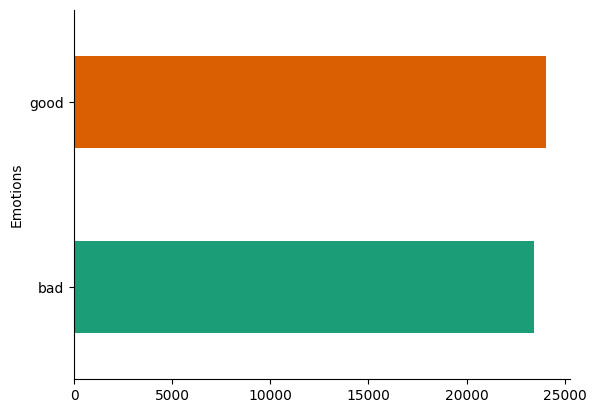

In [ ]:
from matplotlib import pyplot as plt
import seaborn as sns
all_datasets_df.groupby('Emotions').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)
print(all_datasets_df.Emotions.value_counts())

# **Дополнение данных**
Дополнение данных - это процесс, в ходе которого мы создаем новые синтетические образцы данных, добавляя небольшие изменения в наш исходный обучающий набор. Чем больше данных - тем выше будет точность.

Чтобы создать синтетические данные для аудио, мы можем применить введение шума, смещение времени, изменение высоты тона и скорости.
Цель состоит в том, чтобы сделать нашу модель невосприимчивой к этим возмущениям и повысить ее способность к анализу.

Чтобы это сработало, добавление возмущений должно сохранять ту же метку, что и исходная обучающая выборка.

In [ ]:
def noise(data):
    noise_amp = 0.035*np.random.uniform()*np.amax(data)
    data = data + noise_amp*np.random.normal(size=data.shape[0])
    return data

def stretch(data, rate=0.8):
    return librosa.effects.time_stretch(data, rate = rate)

def shift(data):
    shift_range = int(np.random.uniform(low=-5, high = 5)*1000)
    return np.roll(data, shift_range)

def pitch(data, sampling_rate, pitch_factor=0.7):
    return librosa.effects.pitch_shift(data, sr=sampling_rate, n_steps=pitch_factor)



NameError: name 'all_datasets_df' is not defined

In [ ]:
# # возьмём любой образец аудио и посмотрим как эти техники влияют на него
# testpath = all_datasets_df['Path'].sample(1).values[-1]
# print(testpath)
data, sample_rate = librosa.load("./SAVEE_dataset/ALL/DC_a01.wav")

1. Оригинал

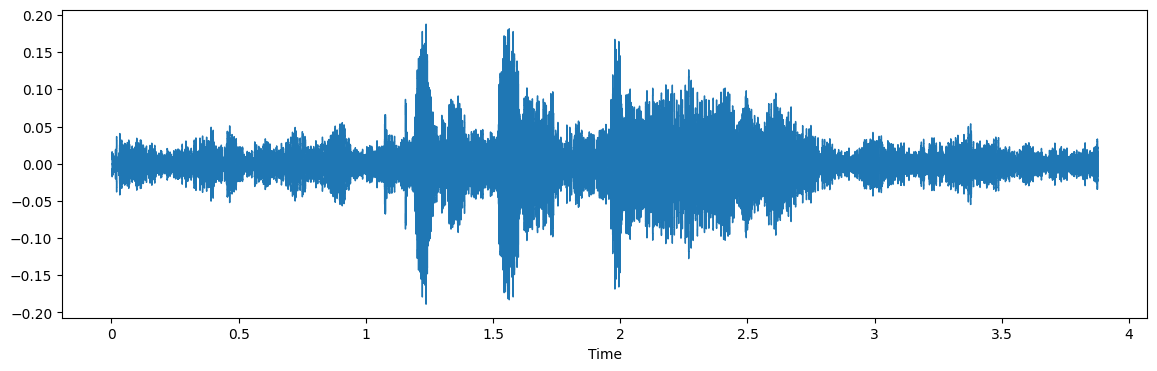

In [ ]:
plt.figure(figsize=(14,4))
librosa.display.waveshow(y=data, sr=sample_rate)
Audio(testpath)

2. Внедрение шумов

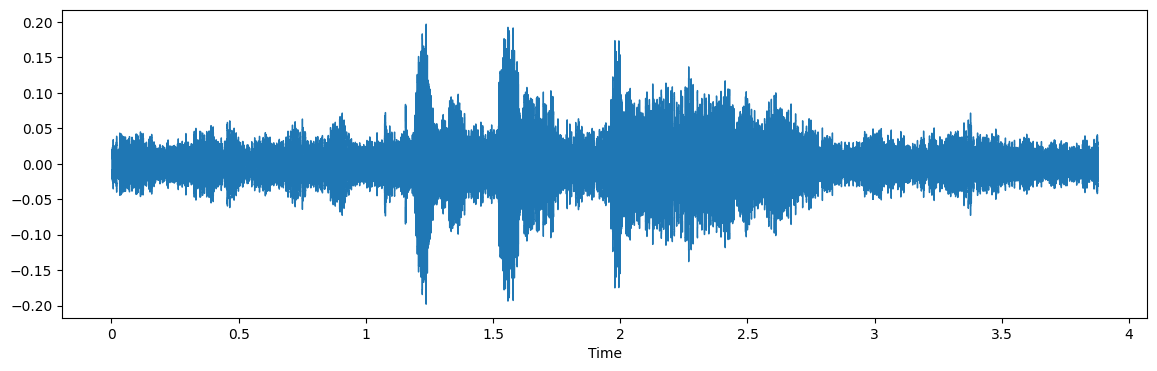

In [ ]:
x = noise(data)
plt.figure(figsize=(14,4))
librosa.display.waveshow(y=x, sr=sample_rate)
Audio(x, rate=sample_rate)

# **3. Растяжка**

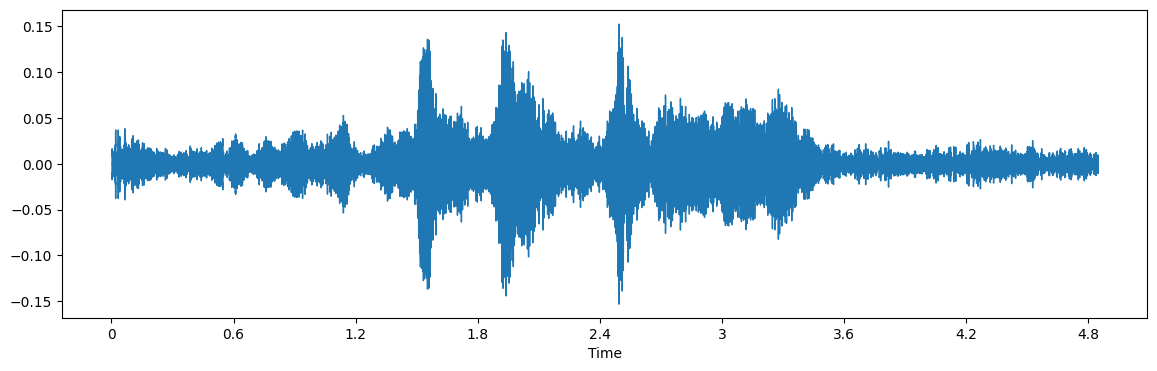

In [ ]:
x = stretch(data)
plt.figure(figsize=(14,4))
librosa.display.waveshow(y=x, sr=sample_rate)
Audio(x, rate=sample_rate)

## **3. Pitch (высота тона)**

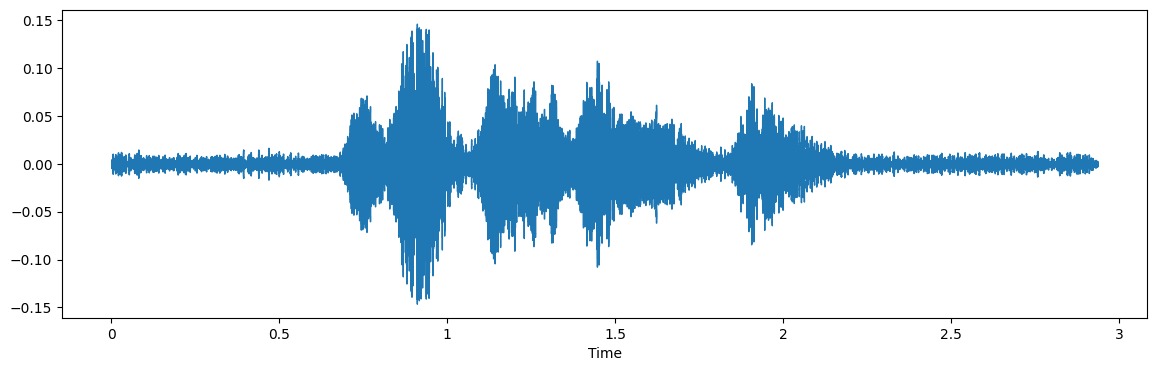

In [ ]:
x = pitch(data, sample_rate)
plt.figure(figsize=(14,4))
librosa.display.waveshow(y=x, sr=sample_rate)
Audio(x, rate=sample_rate)

# **Feature Extraction (Извлечение характеристик)**

- Zero Crossing Rate
- Chroma_stft
- MFCC
- RMS(root mean square) value
- MelSpectogram to train our model.


In [ ]:
def extract_features(data):
    # ZCR
    result = np.array([])
    zcr = np.mean(librosa.feature.zero_crossing_rate(y=data).T, axis=0)
    result = np.hstack((result, zcr)) # Добавляем

    # Chroma_stft
    stft = np.abs(librosa.stft(data))
    chroma_stft = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T, axis=0)
    result = np.hstack((result, chroma_stft)) # Добавляем

    # MFCC
    mfcc = np.mean(librosa.feature.mfcc(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, mfcc)) # Добавляем

    # Root Mean Square Value
    rms = np.mean(librosa.feature.rms(y=data).T, axis=0)
    result = np.hstack((result, rms)) # Добавляем

    # MelSpectogram
    mel = np.mean(librosa.feature.melspectrogram(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, mel)) # Добавляем

    return result

In [ ]:
def get_features(path):
    data, sample_rate = librosa.load(path, duration=2.5, offset=0.6)

    # Оригинал
    res1 = extract_features(data)
    result = np.array(res1)

    # С шумами
    noise_data = noise(data)
    res2 = extract_features(noise_data)
    result = np.vstack((result, res2)) # Добавляем

    # С растяжением и измененным тоном
    # new_data = stretch(data)
    data_stretch_pitch = pitch(data, sample_rate)
    res3 = extract_features(data_stretch_pitch)
    result = np.vstack((result, res3)) # Добавляем

    return result

In [ ]:
print("totally:", all_datasets_df.Path.shape[0])

X, Y = [], []
for path, emotion in tqdm(zip(all_datasets_df.Path, all_datasets_df.Emotions), total=all_datasets_df.Path.shape[0]):
    try:
        feature = get_features(path)
    except (ZeroDivisionError, ValueError):
        continue
    for i in feature:
        X.append(i)
        Y.append(emotion)

totally: 47505


  0%|                                                                      | 61/47505 [00:05<59:12, 13.35it/s]/home/timur/miniforge3/envs/rzd/lib/python3.11/site-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=887
  warnings.warn(
  1%|▌                                                                  | 378/47505 [00:34<1:13:45, 10.65it/s]/home/timur/miniforge3/envs/rzd/lib/python3.11/site-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=512
  warnings.warn(
  1%|▋                                                                    | 443/47505 [00:39<59:40, 13.14it/s]/home/timur/miniforge3/envs/rzd/lib/python3.11/site-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1379
  warnings.warn(
  2%|█▌                                                                  | 1048/47505 [01:37<59:46, 12.95it/s]/tmp/ipykernel_83615/3800147524

In [ ]:
len(X), len(Y), all_datasets_df.Path.shape

(142506, 142506, (47505,))

# **Сохранение характеристик**

Так как предыдущий процесс занял довольно много времени (около 40 минут), лучше всего нам будет его сохранить, чтобы использзовать в дельнейшем.

In [ ]:
Features = pd.DataFrame(X) # В X были сами характеристики, закидываем их напрямую
Features['labels'] = Y # Так как в Y были эмоции, сохраним их в столбец меток
Features=Features.fillna(0)
Features.to_csv('features.csv', index=False)
Features

,0,1,2,3,4,5,6,7,8,9,...,153,154,155,156,157,158,159,160,161,labels
0,0.123671,0.381193,0.403562,0.465832,0.498136,0.416971,0.504806,0.594951,0.703581,0.696308,...,1.139563e-07,1.052742e-07,9.915179e-08,9.461667e-08,9.125229e-08,8.884079e-08,8.709303e-08,8.596241e-08,8.526430e-08,good
1,0.183820,0.410349,0.441778,0.470464,0.557614,0.494020,0.490430,0.577081,0.668789,0.740100,...,2.908974e-04,2.917041e-04,2.887590e-04,2.844633e-04,2.911336e-04,2.876307e-04,2.812586e-04,2.896894e-04,2.801751e-04,good
2,0.125538,0.339101,0.379856,0.407655,0.512245,0.418090,0.429237,0.530872,0.656904,0.689270,...,1.652448e-07,1.466060e-07,1.345029e-07,1.245413e-07,1.171293e-07,1.126577e-07,1.100651e-07,9.485531e-08,5.520075e-08,good
3,0.096928,0.530662,0.413637,0.334755,0.332222,0.360253,0.419456,0.377426,0.362375,0.390618,...,1.659414e-06,1.539385e-06,1.454961e-06,1.392565e-06,1.346442e-06,1.313580e-06,1.289846e-06,1.274641e-06,1.265223e-06,good
4,0.210870,0.687519,0.601048,0.497738,0.485981,0.498186,0.494196,0.470695,0.449606,0.477019,...,1.283471e-02,1.210758e-02,1.268997e-02,1.217010e-02,1.211716e-02,1.216397e-02,1.202614e-02,1.156141e-02,1.233125e-02,good
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
142501,0.303923,0.715377,0.705925,0.721110,0.666299,0.650261,0.588437,0.571138,0.612063,0.650908,...,5.980465e-05,5.983522e-05,6.300198e-05,6.328417e-05,6.117358e-05,6.358785e-05,6.305572e-05,5.939649e-05,6.221165e-05,good
142502,0.128861,0.692645,0.636484,0.596423,0.661575,0.585223,0.498210,0.504134,0.539426,0.594517,...,1.079791e-11,9.898582e-12,9.432878e-12,9.820180e-12,1.007320e-11,1.032358e-11,1.083241e-11,1.144190e-11,8.216196e-12,good
142503,0.063888,0.383902,0.443202,0.434616,0.499837,0.723374,0.478100,0.387448,0.410968,0.527752,...,8.026444e-08,7.531658e-08,7.186524e-08,6.932598e-08,6.746814e-08,6.617127e-08,6.523965e-08,6.466423e-08,6.430421e-08,good
142504,0.201681,0.516577,0.562763,0.548643,0.587800,0.759273,0.568057,0.453278,0.473405,0.595645,...,1.850192e-03,1.864319e-03,1.820246e-03,1.848437e-03,1.862322e-03,1.895478e-03,2.000906e-03,1.868027e-03,1.846699e-03,good


Испорт характеристик из файла

Этот блок кода нужнозапускать тогда, когда мы хотим не вычислять характеристики заново, а взять их из файла.

In [ ]:
Features = pd.read_csv('features.csv')

# **Подготовка данных**

Нужно подготовить данные к обучению - нормализовать и разделить на тренировочную и тестовую выборки. Так как эмоции - признак в текстовом формате, его нужно кодировать в понятные машине числа. Причём так, чтобы во время обучения она не подумала, что в первом столбце, с эмоциями, что между ними есть какая-то связь. Для этого используем OneHotEncoder.

Этот кодировщик берёт столбец с категориальными данными, который был предварительно закодирован в признак, и создаёт для него несколько новых столбцов. Числа заменяются на единицы и нули, в зависимости от того, какому столбцу какое значение присуще.

- X - Характеристики (вход)
- Y - Эмоции (выход)

In [ ]:
X = Features.iloc[: ,:-1].values
Y = Features['labels'].values

Y = np.array(Y).reshape(-1,1) # Переведём в диапозон от -1 до 1
encoder = OneHotEncoder()
Y = encoder.fit_transform(Y).toarray()

# splitting data
x_train, x_test, y_train, y_test = train_test_split(X, Y, random_state=42, shuffle=True, test_size=0.20)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((114004, 162), (114004, 2), (28502, 162), (28502, 2))

In [ ]:
X_train = x_train.reshape(x_train.shape[0] , x_train.shape[1] , 1)
X_test = x_test.reshape(x_test.shape[0] , x_test.shape[1] , 1)

In [ ]:
# scaling our data with sklearn's Standard scaler
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((114004, 162), (114004, 2), (28502, 162), (28502, 2))


# **CNN model**

Мы будем делать "Свёрточную нейронную сеть", так как в проктах других авторов она показывала хорошую точность по сравнению с LSTM, CLSTM и другими типами. К тому же, нейросети этого типа намного быстрее обучать.

https://w.wiki/4jCR



In [ ]:
import keras
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding
from keras.layers import LSTM,BatchNormalization , GRU
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from keras.layers import Input, Flatten, Dropout, Activation
from keras.layers import Conv1D, MaxPooling1D, AveragePooling1D
from keras.models import Model
from keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import SGD
import tensorflow.keras.layers as layers


from keras.callbacks import ModelCheckpoint, EarlyStopping,ReduceLROnPlateau
model_checkpoint = ModelCheckpoint('best_model1_weights.keras', monitor='val_accuracy', save_best_only=True)
early_stop=EarlyStopping(monitor='val_accuracy',mode='max',patience=10,restore_best_weights=True)
lr_reduction=ReduceLROnPlateau(monitor='val_accuracy',patience=3,verbose=1,factor=0.5,min_lr=0.000005)

In [ ]:
#Reshape for CNN MODEL

x_traincnn = np.expand_dims(x_train, axis=2)
x_testcnn = np.expand_dims(x_test, axis=2)
x_traincnn.shape, y_train.shape, x_testcnn.shape, y_test.shape



((114004, 162, 1), (114004, 2), (28502, 162, 1), (28502, 2))

In [ ]:
model = tf.keras.Sequential([
    layers.Conv1D(512,kernel_size=5, strides=1,padding='same', activation='relu',input_shape=(X_train.shape[1],1)),
    layers.BatchNormalization(),
    layers.MaxPool1D(pool_size=5,strides=2,padding='same'),

    layers.Conv1D(512,kernel_size=5,strides=1,padding='same',activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPool1D(pool_size=5,strides=2,padding='same'),
    Dropout(0.2),  # Add dropout layer after the second max pooling layer

    layers.Conv1D(256,kernel_size=5,strides=1,padding='same',activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPool1D(pool_size=5,strides=2,padding='same'),

    layers.Conv1D(256,kernel_size=3,strides=1,padding='same',activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPool1D(pool_size=5,strides=2,padding='same'),
    Dropout(0.2),  # Add dropout layer after the fourth max pooling layer

    layers.Conv1D(128,kernel_size=3,strides=1,padding='same',activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPool1D(pool_size=3,strides=2,padding='same'),
    Dropout(0.2),  # Add dropout layer after the fifth max pooling layer

    layers.Flatten(),
    layers.Dense(512,activation='relu'),
    layers.BatchNormalization(),
    layers.Dense(2,activation='softmax')
])
model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])
model.summary()


/home/timur/miniforge3/envs/rzd/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2024-06-15 01:17:55.975281: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-06-15 01:17:55.975528: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 162, 512)       │         3,072 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 162, 512)       │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 81, 512)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 81, 512)        │     1,311,232 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 81, 512)        │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 41, 512)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 41, 512)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 41, 256)        │       655,616 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 41, 256)        │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, 21, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_3 (Conv1D)               │ (None, 21, 256)        │       196,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 21, 256)        │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_3 (MaxPooling1D)  │ (None, 11, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 11, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_4 (Conv1D)               │ (None, 11, 128)        │        98,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 11, 128)        │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_4 (MaxPooling1D)  │ (None, 6, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 6, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 768)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │       393,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │         1,02

 Total params: 2,668,674 (10.18 MB)

 Trainable params: 2,664,322 (10.16 MB)

 Non-trainable params: 4,352 (17.00 KB)

In [ ]:
history = model.fit(
    x_traincnn,
    y_train,
    epochs=50,
    validation_data=(x_testcnn, y_test),
    batch_size=64,
    callbacks=[early_stop,lr_reduction,model_checkpoint]
    )

Epoch 1/50


I0000 00:00:1718403492.076331  121053 service.cc:145] XLA service 0x7f63cc001dd0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1718403492.076360  121053 service.cc:153]   StreamExecutor device (0): NVIDIA GeForce GTX 1060 6GB, Compute Capability 6.1
2024-06-15 01:18:12.159253: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-06-15 01:18:12.546353: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907
2024-06-15 01:18:16.296382: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 32.53GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


   7/1782 ━━━━━━━━━━━━━━━━━━━━ 49s 28ms/step - accuracy: 0.5072 - loss: 0.9183

I0000 00:00:1718403500.918121  121053 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1781/1782 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.5298 - loss: 0.7482

2024-06-15 01:19:06.081091: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 32.52GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


1782/1782 ━━━━━━━━━━━━━━━━━━━━ 65s 30ms/step - accuracy: 0.5299 - loss: 0.7482 - val_accuracy: 0.5637 - val_loss: 0.6792 - learning_rate: 0.0010
Epoch 2/50
1782/1782 ━━━━━━━━━━━━━━━━━━━━ 45s 25ms/step - accuracy: 0.5688 - loss: 0.6826 - val_accuracy: 0.5265 - val_loss: 0.7352 - learning_rate: 0.0010
Epoch 3/50
1782/1782 ━━━━━━━━━━━━━━━━━━━━ 45s 26ms/step - accuracy: 0.5869 - loss: 0.6725 - val_accuracy: 0.5896 - val_loss: 0.6666 - learning_rate: 0.0010
Epoch 4/50
1782/1782 ━━━━━━━━━━━━━━━━━━━━ 45s 25ms/step - accuracy: 0.5958 - loss: 0.6645 - val_accuracy: 0.5474 - val_loss: 0.6956 - learning_rate: 0.0010
Epoch 5/50
1782/1782 ━━━━━━━━━━━━━━━━━━━━ 46s 26ms/step - accuracy: 0.6061 - loss: 0.6566 - val_accuracy: 0.6019 - val_loss: 0.6599 - learning_rate: 0.0010
Epoch 6/50
1782/1782 ━━━━━━━━━━━━━━━━━━━━ 45s 26ms/step - accuracy: 0.6158 - loss: 0.6504 - val_accuracy: 0.5924 - val_loss: 0.6899 - learning_rate: 0.0010
Epoch 7/50
1782/1782 ━━━━━━━━━━━━━━━━━━━━ 45s 25ms/step - accuracy: 0.6226 

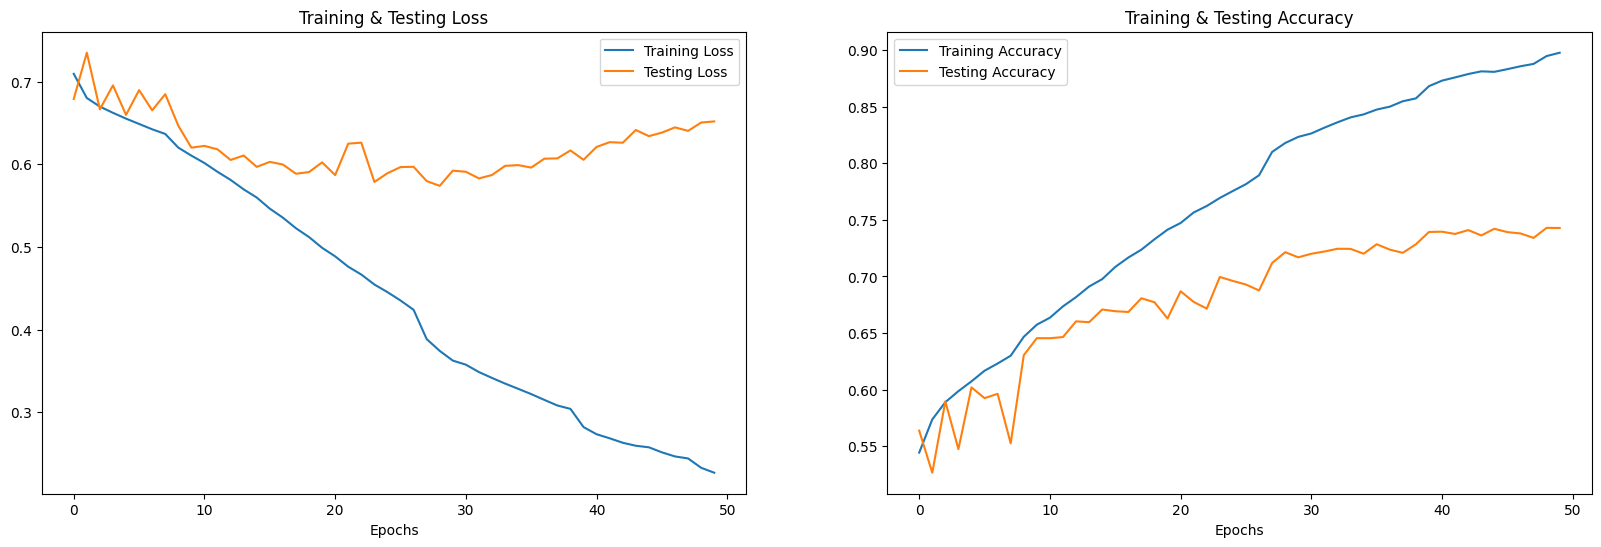

In [ ]:
import matplotlib.pyplot as plt

epochs = [i for i in range(50)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
test_acc = history.history['val_accuracy']
test_loss = history.history['val_loss']

fig.set_size_inches(20,6)
ax[0].plot(epochs , train_loss , label = 'Training Loss')
ax[0].plot(epochs , test_loss , label = 'Testing Loss')
ax[0].set_title('Training & Testing Loss')
ax[0].legend()
ax[0].set_xlabel("Epochs")

ax[1].plot(epochs , train_acc , label = 'Training Accuracy')
ax[1].plot(epochs , test_acc , label = 'Testing Accuracy')
ax[1].set_title('Training & Testing Accuracy')
ax[1].legend()
ax[1].set_xlabel("Epochs")
plt.show()

In [ ]:
pred_test = model.predict(x_test)
y_pred = encoder.inverse_transform(pred_test)

y_test = encoder.inverse_transform(y_test)

df = pd.DataFrame(columns=['Predicted Labels', 'Actual Labels'])
df['Predicted Labels'] = y_pred.flatten()
df['Actual Labels'] = y_test.flatten()

r_counter, w_counter = 0, 0

lp=list()
la=list()

for n, i in df.iterrows():
    if i['Predicted Labels'] == i['Actual Labels']:
        r_counter+=1
    else:
        w_counter+=1
        lp.append(i['Predicted Labels'])
        la.append(i['Actual Labels'])

wdf = pd.DataFrame(
    {'Predicted': lp,
     'Actual': la,
    })

print(r_counter / len(df))
wdf.to_csv('test.csv', index=False)
print(len(df))

891/891 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step
0.7430004911936005
28502


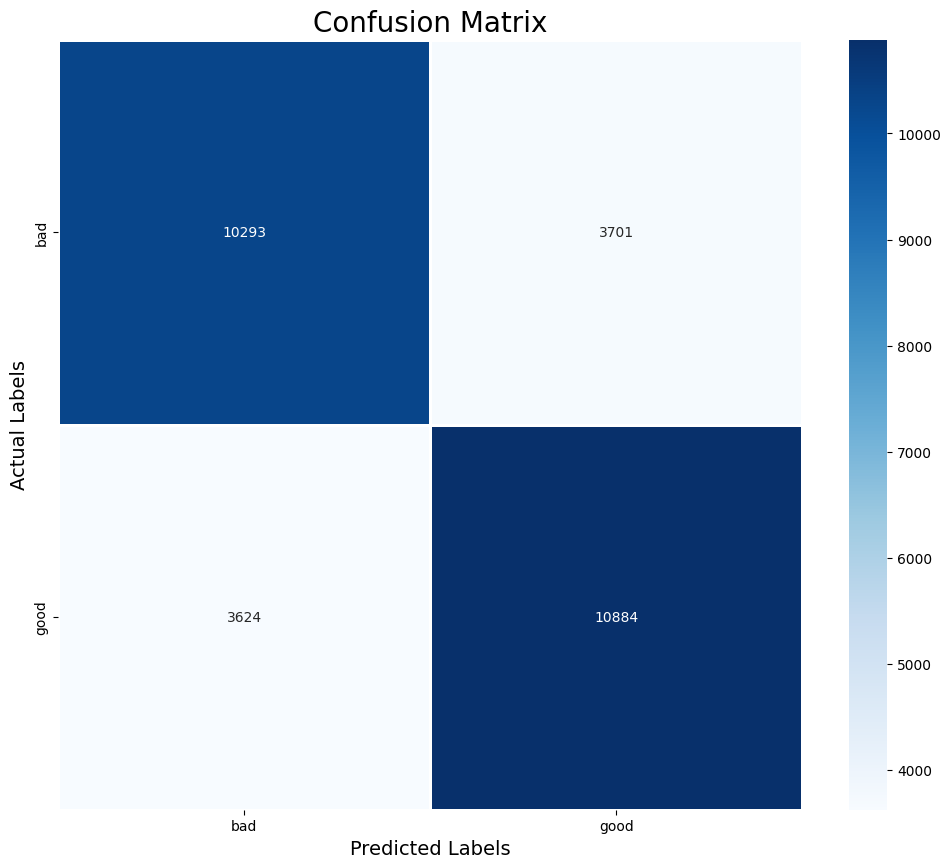

In [ ]:
import seaborn as sns
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize = (12, 10))
cm = pd.DataFrame(cm , index = [i for i in encoder.categories_] , columns = [i for i in encoder.categories_])
sns.heatmap(cm, linecolor='white', cmap='Blues', linewidth=1, annot=True, fmt='')
plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted Labels', size=14)
plt.ylabel('Actual Labels', size=14)
plt.show()

In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         bad       0.74      0.74      0.74     13994
        good       0.75      0.75      0.75     14508

    accuracy                           0.74     28502
   macro avg       0.74      0.74      0.74     28502
weighted avg       0.74      0.74      0.74     28502



# **Сохраним модель**


In [ ]:
from tensorflow.keras.models import Sequential, model_from_json
model_json = model.to_json()
with open("CNN_model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("CNN_model.weights.h5")
print("Saved model to disk")

Saved model to disk


In [ ]:
# Saving scaler
with open('scaler.pickle', 'wb') as f:
    pickle.dump(scaler, f)

# Saving encoder
with open('encoder.pickle', 'wb') as f:
    pickle.dump(encoder, f)

# **Скрипт использования**

In [ ]:
%env CUDA_VISIBLE_DEVICES=""

env: CUDA_VISIBLE_DEVICES=""


In [ ]:
from tensorflow.keras.models import Sequential, model_from_json
from tensorflow import device as tf_device
import pickle
import librosa
import numpy as np


json_file = open('CNN_model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("CNN_model.weights.h5")
print("Loaded model from disk")


with open('scaler.pickle', 'rb') as f:
    scaler = pickle.load(f)

with open('encoder.pickle', 'rb') as f:
    encoder = pickle.load(f)

Loaded model from disk


In [ ]:
def extract_features(data, sample_rate):
    # ZCR
    result = np.array([])
    zcr = np.mean(librosa.feature.zero_crossing_rate(y=data).T, axis=0)
    result = np.hstack((result, zcr)) # Добавляем

    # Chroma_stft
    stft = np.abs(librosa.stft(data))
    chroma_stft = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T, axis=0)
    result = np.hstack((result, chroma_stft)) # Добавляем

    # MFCC
    mfcc = np.mean(librosa.feature.mfcc(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, mfcc)) # Добавляем

    # Root Mean Square Value
    rms = np.mean(librosa.feature.rms(y=data).T, axis=0)
    result = np.hstack((result, rms)) # Добавляем

    # MelSpectogram
    mel = np.mean(librosa.feature.melspectrogram(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, mel)) # Добавляем

    return result

In [ ]:
def get_predict_feat(path):
    d, sample_rate= librosa.load(path, duration=2.5, offset=0.6)
    res=extract_features(d, sample_rate)
    result=np.array(res)
    result=np.reshape(result,newshape=(1,162))
    i_result = scaler.transform(result)
    final_result=np.expand_dims(i_result, axis=2)

    return final_result

In [ ]:
res=get_predict_feat("pm(p).wav")
print(res.shape)

(1, 162, 1)


In [ ]:
emotions1 = {1:'bad', 2:'good'}
def prediction(path1):
    res=get_predict_feat(path1)
    predictions=loaded_model.predict(res)
    y_pred = encoder.inverse_transform(predictions)
    print(y_pred[0][0])

In [ ]:
prediction("norm2.wav")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
good
